In [27]:
import pandas as pd
import numpy as np
import pickle
import os
import plotly.express as px

os.chdir(r"H:\all\RL_Shrinkage_2024")

import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3])

from helpers import rl_covmat_ests_for_dataset as estimators
from helpers import helper_functions as hf
from helpers import eval_funcs_multi_target
from helpers import eval_funcs

from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from ONE_YR.NonLinear_Shrinkage import helper_functions_NL_RL as NL_hf

from collections import Counter

In [28]:
def get_ann_vola(return_df):
    return round(return_df.std() * np.sqrt(252) * 100, 3)

def get_ann_ret(return_df):
    return round(return_df.mean() * 252 * 100, 3)

In [29]:
# define factors
all_factors = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
               1.9, 2.0]
# num eigenvalues to modify
num_eigenvalues = [1, 5, 10, 25, 50]

'''
Description:
all_res is the 21 day lead std dev of the returns of the minvar portfolio
all_rawres is the return of each day
'''
all_rawres = {}
all_res = {}
qis_grid_data = r"H:\all\RL_Shrinkage_2024\ONE_YR\preprocessing\qis_eigenvalue_grid_data"
for num_ev in num_eigenvalues:
    df = pd.read_csv(qis_grid_data + f"\\qis_grid_allres_{num_ev}_evs.csv")
    all_res[num_ev] = df
    df = pd.read_csv(qis_grid_data + f"\\qis_grid_all_rawres_{num_ev}_evs.csv")
    all_rawres[num_ev] = df

oos_factor_results_MEANS = {}
for k, v in all_rawres.items():
    tmp = round(v.iloc[5040:,].mean() * 252 * 100, 2)
    oos_factor_results_MEANS[k] = tmp
oos_factor_results_MEANS = pd.DataFrame(oos_factor_results_MEANS)

oos_factor_results_VOLS = {}
for k, v in all_rawres.items():
    tmp = round(v.iloc[5040:,].std() * np.sqrt(252) * 100, 2)
    oos_factor_results_VOLS[k] = tmp
oos_factor_results_VOLS = pd.DataFrame(oos_factor_results_VOLS)

allres_min_idxes_full = {}
for k, v in all_res.items():
    minima = v.idxmin(axis=1)[: -21].values
    minima = np.insert(minima, 0, np.repeat(["1.0"], 21))
    allres_min_idxes_full[k] = minima
allres_min_idxes_full_df = pd.DataFrame(allres_min_idxes_full)

# for sanity check: BIASED version should generally be better than
# non biased version as it is literally the minimum over the future 21 days
# so using it as a signal should outperform
allres_min_idxes_BIASED = {}
for k, v in all_res.items():
    minima = v.idxmin(axis=1).values
    allres_min_idxes_BIASED[k] = minima
allres_min_idxes_BIASED_df = pd.DataFrame(allres_min_idxes_BIASED)

# simple argmin rule, with full allres_min, should be same results as above
res_simple_argmin_rule_v2 = {}
for num_ev in num_eigenvalues:
    tmp = np.diag(all_rawres[num_ev].loc[:, allres_min_idxes_full[num_ev]])[5040:]
    res_simple_argmin_rule_v2[num_ev] = tmp
res_simple_argmin_rule_v2 = pd.DataFrame(res_simple_argmin_rule_v2)

# neue version, korrekt
res_simple_argmin_rule_v2 = {}
for num_ev in num_eigenvalues:
    idx = np.repeat(allres_min_idxes_full[num_ev][list(range(0, allres_min_idxes_full[num_ev].shape[0], 21))], 21)
    tmp = np.diag(all_rawres[num_ev].loc[:, idx])[5040:]
    res_simple_argmin_rule_v2[num_ev] = tmp
res_simple_argmin_rule_v2 = pd.DataFrame(res_simple_argmin_rule_v2)

# simple argmin rule, biased (as a sanity check)
res_simple_argmin_rule_biased = {}
for num_ev in num_eigenvalues:
    tmp = np.diag(all_rawres[num_ev].loc[:, allres_min_idxes_BIASED[num_ev]])[5040:]
    res_simple_argmin_rule_biased[num_ev] = tmp
res_simple_argmin_rule_biased = pd.DataFrame(res_simple_argmin_rule_biased)

# neue version, korrekt
res_simple_argmin_rule_biased = {}
for num_ev in num_eigenvalues:
    idx_biased = np.repeat(allres_min_idxes_BIASED[num_ev][list(range(0, allres_min_idxes_BIASED[num_ev].shape[0], 21))], 21)
    tmp = np.diag(all_rawres[num_ev].loc[:, idx_biased])[5040:]
    res_simple_argmin_rule_biased[num_ev] = tmp
res_simple_argmin_rule_biased = pd.DataFrame(res_simple_argmin_rule_biased)


# actual argmin of rawres (as a sanity check)
res_actual_argmin = {}
for num_ev in num_eigenvalues:
    res_actual_argmin[num_ev] = []
    for i in range(5313//21):
        tmp_data = all_rawres[num_ev].iloc[5040 + 21*i: 5040 + 21*(i+1)]
        curmin_idx = tmp_data.std().idxmin()
        curmin = tmp_data.loc[:, curmin_idx]
        res_actual_argmin[num_ev] += curmin.tolist()
res_actual_argmin = pd.DataFrame(res_actual_argmin)


res_simple_RAWRES_argmin_rule = {}
for num_ev in num_eigenvalues:
    rawres_min_signal = all_rawres[num_ev].rolling(window=21, min_periods=21).std().idxmin(axis=1, skipna=True).fillna('1.0')
    tmp = (all_rawres[num_ev].loc[:, rawres_min_signal])
    tmp = np.diag(tmp)[5040:]
    res_simple_RAWRES_argmin_rule[num_ev] = tmp
res_simple_RAWRES_argmin_rule = pd.DataFrame(res_simple_RAWRES_argmin_rule)

res_actual_argmin_nonbiased = {}
for num_ev in num_eigenvalues:
    res_actual_argmin_nonbiased[num_ev] = []
    for i in range(5313//21):
        idx_min_data = all_rawres[num_ev].iloc[5040 - 21 + 21*i: 5040 - 21 + 21*(i+1)]
        curmin_idx = idx_min_data.std().idxmin()
        tmp_data = all_rawres[num_ev].iloc[5040 + 21*i: 5040 + 21*(i+1)]
        curmin = tmp_data.loc[:, curmin_idx]
        res_actual_argmin_nonbiased[num_ev] += curmin.tolist()
res_actual_argmin_nonbiased = pd.DataFrame(res_actual_argmin_nonbiased)

model_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\results"
lgbm_returns = pd.read_csv(model_path + "\\lgbm_model_returns_v2.csv", index_col=0)
lgbm_returns.columns = lgbm_returns.columns.astype(int)

qis_rets = all_rawres[1].iloc[5040:, ].loc[:, '1.0']

C:\Users\dkostovic\AppData\Local\Temp\6\ipykernel_32924\1390461599.py:94: FutureWarning:

The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\dkostovic\AppData\Local\Temp\6\ipykernel_32924\1390461599.py:94: FutureWarning:

The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\dkostovic\AppData\Local\Temp\6\ipykernel_32924\1390461599.py:94: FutureWarning:

The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\dkostovic\AppData\Local\Temp\6\ipykernel_32924\1390461599.py:94: FutureWarning:

The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\dkostovic\AppData\Local\Temp\6\ipykernel_32924\13904615

In [30]:
qis_rets = all_rawres[1].iloc[5040:, ].loc[:, '1.0'].mean() * 252 * 100
qis_rets = round(qis_rets, 3)
qis_volas = all_rawres[1].iloc[5040:, ].loc[:, '1.0'].std() * np.sqrt(252) * 100
qis_volas = round(qis_volas, 3)


## Explanation of the Data used for training and evaluating the model

In the whole dataset we have roughly 10'000 trading days. Theoretically we could build a Minimum Variance portfolio **every** trading day, and hold it for 21 days. This gives us 21 days of return data, which we then use to calculate the annualized volatility of said portfolio.

Hence, the argmin signal of rebalancing date *i* is the Factor (in {0.5,...,2.0}), that would have led to the MVP with the lowest volatility over the next 21 trading days. Hence, this is a simple autoregressive signal. Of course, we lag it by 21 days, in order not to peek in the future. 
I experimented both with the factor itself as input signal but also with the resulting 21 day MVP volatility.

Input Matrix X is given by (or a subset thereof):
- Volatility of MVP built by using optimal factor on CVC/QIS.
- Optimal Factor itself.
- Yearly and Monthly Volatility EW portfolio (vola of the EW PF daily returns) of currently included stocks
- Trace of sample covmat
- Yearly and Monthly Vola as well as Yearly and Monthly Timeseries Momentum for the current stock universe
- Mean of pairwise correlations of current stock universe returns
This results in a $X \in (n \times 9)$ Input Matrix. We can also do a second version including the factor data (13 factor features).


For the Y signal I tried two things:
- The argmin signal (the volatility corresponding to the optimal factor) without a lag of course. I.e., we predict the OOS volatility of each of the MVP built using each of the factors (I.e., we fit a 16 **separate** models for each of the factors, using the same input data, and pick the factor which leads the lowest predicted OOS volatility).
- Alternatively, I tried to predict only the optimal Factor (i.e., {0.5, 0.6, ..., 2.0}) directly. I tried doing this as a classification and a regression task but the latter worked better (i.e., treat the optimal factors as continuous and round the predicted optimal factor to the nearest integer). 
- $Y \in  (n \times 16)$  OR $Y \in (n \times 1)$

Hence, as the Y signals during training are 21 days forward looking, we always have a gap of 21 days between train and test sets. This gap persists for every rebalancing date.






## Results of current model
Comparison of simple signals, constant factor, and our lgbm model.

The current model is a light GBM model and uses **the same** inputs in the Linear (CVC) model and the NonLinear (QIS) model. Now I have modified it to be the same procedure.
In the nonlinear case this is: Given a the $p$ largest QIS-Eigenvalues, apply a factor in {0.5, 0.6, ..., 1.9, 2.0} to the $p$ largest Eigenvalues, where $p \in \{1, 5, 10, 25, 50\}$. 
The factor is the actual learnable "action" of our RL agent. Note: the same factor is applied to all $p$ eigenvalues.

Note that the actual argmin is the actual obtainable minimum when working with the original QIS Eigenvalues times the above factor and rebalancing every 21 days, i.e., every 21 days we might change the factor for the rebalancing.

## Model Used
- Train Size = 252 (so nowhere near the whole dataset is used, which is about 5000 datapoints)
- opt factors and the resulting volatility as input
- factors
- some local measures (vola of EW universe, TS momentum, correlations between stocks, ..)

- Y = Opt. Factors: $\{0.5, 0.6,..,2.0 \}$

- Model: LGBM Regressor


## Results

Note, the actual_argmin is not a model but picking the factor resulting in the MVP with the lowest volatility in each rebalancing date.

Note 2, these results are without extensive parameter tuning. Also using the same data and parameters in the linear Shrinkage (CVC) case yields a standard deviation of (9.807, 10.59) which is also better than the 10.75 by original CVC.

Note 3, this is all done in the case where p (or N) = 500, and n (or T) = 252, so the hardest of the cases I considered in my master's thesis.

In [31]:
qis_volas = pd.Series([qis_volas for _ in range(5)])
qis_volas.index = num_eigenvalues
qis_rets = pd.Series([qis_rets for _ in range(5)])
qis_rets.index = num_eigenvalues


names = ["lgbm_model", "simple_argmin_rule", "actual_argmin", "QIS"]
volas = [get_ann_vola(lgbm_returns), get_ann_vola(res_simple_argmin_rule_v2), 
         get_ann_vola(res_simple_argmin_rule_biased), qis_volas ]

rets = [get_ann_ret(lgbm_returns), get_ann_ret(res_simple_argmin_rule_v2), 
        get_ann_ret(res_simple_argmin_rule_biased), qis_rets]

volas = pd.DataFrame(volas, index=names)
rets = pd.DataFrame(rets, index=names)


# with different parameters (slightly tuned on case with 10 eigenvalues):
# for lookback windows 504 and 252 trading days
# using CVC for mvp results in std. dev. of 10.75
'''
1: [(9.504, 10.335), (9.404, 10.336)],
5: [(9.556, 10.343), (9.614, 10.334)],
10: [(9.537, 10.305), (9.602, 10.314)],
25: [(9.596, 10.358), (9.714, 10.357)],
50: [(9.679, 10.365), (9.683, 10.353)]})
'''

volas

,1,5,10,25,50
lgbm_model,10.360,10.358,10.323,10.356,10.335
simple_argmin_rule,10.424,10.324,10.318,10.363,10.350
actual_argmin,10.204,10.146,10.131,10.121,10.113
QIS,10.378,10.378,10.378,10.378,10.378


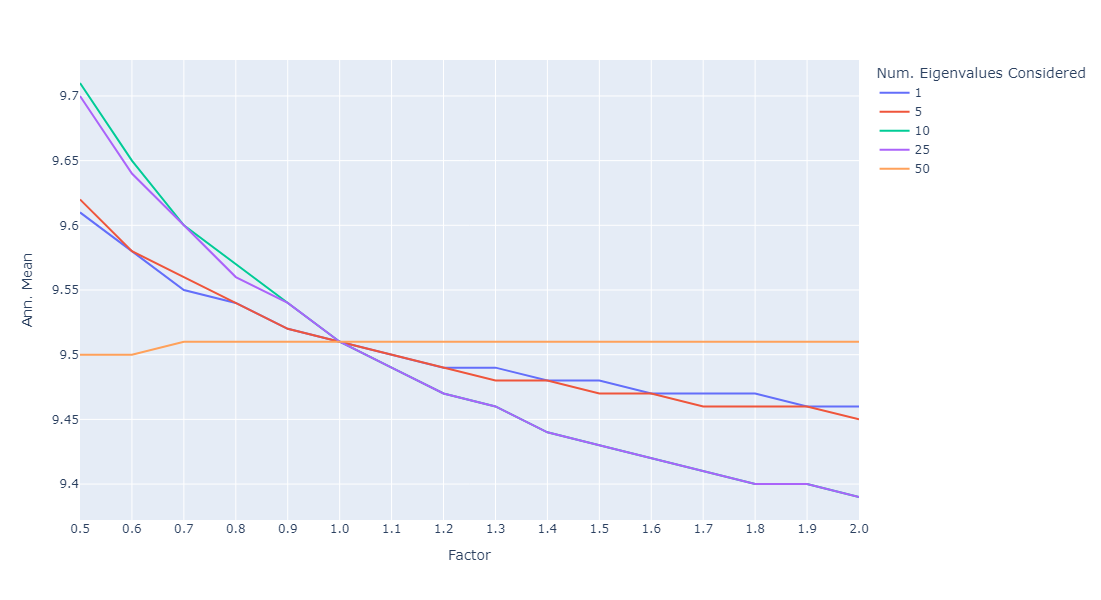

In [15]:
px.line(oos_factor_results_MEANS, labels={"value": "Ann. Mean", "index": "Factor", "variable": "Num. Eigenvalues Considered"},
       height=600, width = 1100)

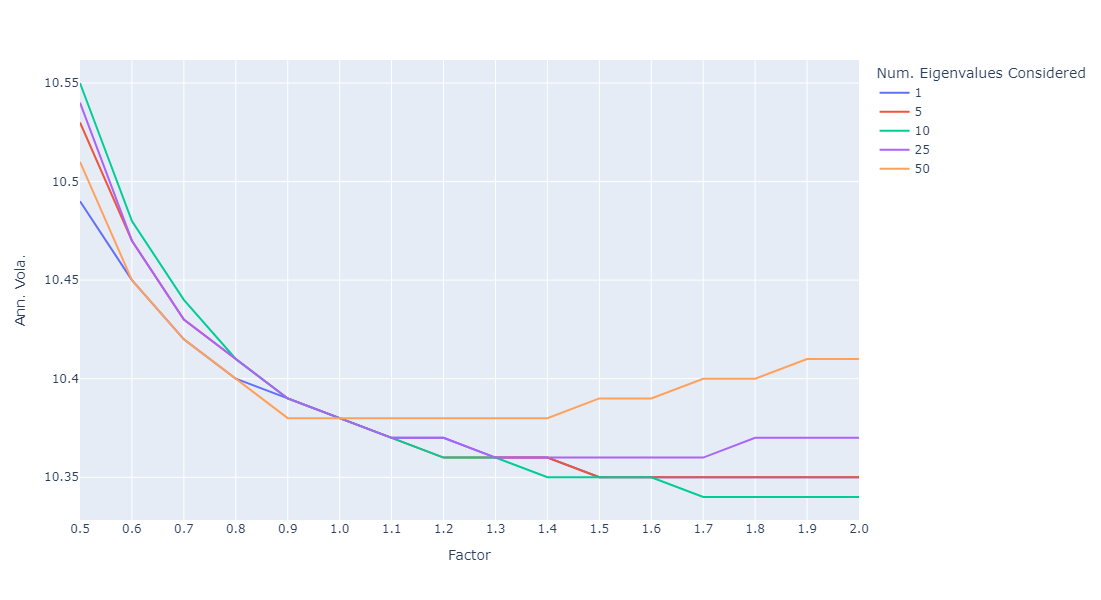

In [16]:
px.line(oos_factor_results_VOLS, labels={"value": "Ann. Vola.", "index": "Factor", "variable": "Num. Eigenvalues Considered"},
       height=600, width = 1100)

## Per our analysis, the Simple Argmin Signal is clearly the strongest signal. Hence we want to analyze it and look at its persistence over time.
- How much does the optimal factor change from rebalancing day to rebalancing day (important question as our argmin signal is our target variable at the same time. Hence a strong autocorrelation makes prediction easier)?
- How much does our Model differ from that?

allres_min_idxes_full_df and res_simple_argmin_rule_biased are exactly shifted by 21 days, hence 
in a training example the first index of allres_min_idxes_full_df is used as a signal, while we try to predict the first index of allres_min_idxes_BIASED_df. Therefore, it makes sense to see how far these are apart in general. 

In [17]:
data_len = allres_min_idxes_full_df[num_ev].shape[0]

#### The minima are generally obtained at the extreme factors (0.5 and 2.0). Hence it is almost a binary learning task for our model. I.e., 188 out of

In [18]:
print(Counter(allres_min_idxes_BIASED_df[num_ev].astype(float)[list(range(1, data_len, 21))]) )

Counter({0.5: 188, 2.0: 145, 0.6: 29, 0.8: 27, 0.7: 20, 0.9: 16, 1.3: 13, 1.0: 13, 1.6: 10, 1.1: 9, 1.2: 7, 1.4: 6, 1.8: 5, 1.7: 3, 1.9: 1, 1.5: 1})


#### Looking at the lagged (lagged by a rebalancing date, i.e., 21 trading days) optimal factors, in 165 cases, the same factor is again the one with the lowest volatility, but in 144 cases it is the other extreme (0.5 -> 2.0 / 2.0 -> 0.5).

In [19]:
num_ev = 10
argmins = pd.concat([allres_min_idxes_full_df[num_ev].astype(float)[list(range(1, data_len, 21))], 
                     allres_min_idxes_BIASED_df[num_ev].astype(float)[list(range(1, data_len, 21))]], 
                    axis=1)
diffs = np.abs(argmins.diff(axis=1).dropna(axis=1))
Counter(round(diffs[num_ev],1))

Counter({0.0: 165,
         1.5: 144,
         0.2: 25,
         1.4: 16,
         0.1: 16,
         1.2: 15,
         1.0: 15,
         1.3: 15,
         1.1: 13,
         0.4: 13,
         0.7: 13,
         0.6: 10,
         0.5: 9,
         0.9: 9,
         0.3: 8,
         0.8: 7})

### LGBM Model Predictions

In [40]:
lgbm_preds = pd.read_csv(model_path + "\\lgbm_model_predictions_v2.csv", index_col=0)
#lgbm_preds.columns = lgbm_preds.columns.astype(int)

In [41]:
Counter(lgbm_preds['10'])

Counter({0.5: 693,
         0.7: 546,
         0.8: 525,
         1.1: 378,
         1.0: 357,
         0.6: 336,
         1.7: 315,
         1.5: 294,
         1.4: 294,
         1.2: 273,
         1.9: 252,
         0.9: 252,
         1.6: 231,
         2.0: 231,
         1.3: 189,
         1.8: 147})

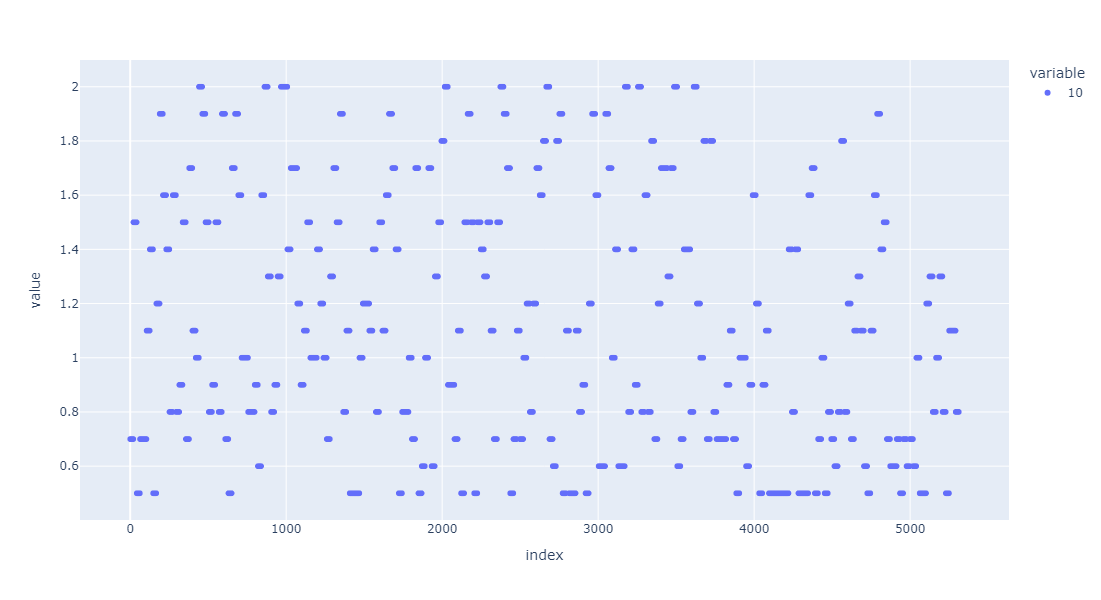

In [44]:
px.scatter(lgbm_preds['10'], height=600)

## Plot of what the actual optimal factors would be between 0.5 and 2.0, depending on numbers of eigenvalues considered.
- We cannot see any time-specific trend or any trend that depends on the eigenvalues considered for QIS
- For CVC, the optimal factors are much more skewed towards higher factors (NOT plotted here). This is in line with the results of my master's thesis, where I observed that CVC chooses **too low** shrinkage intensities. (Bei CVC sind die Factors aber auf die Shrinkage Intensity angewendet und nicht auf die Eigenvalues!)
- 
- Nonetheless, it seems that the optimal factors are clustered around the extremes. Could also extend the factors even further to see whether it makes a difference.


In [20]:
res = []
for num_ev in num_eigenvalues:
    tmp = allres_min_idxes_BIASED_df[num_ev][list(range(1, data_len, 21))].astype(float)
    res.append(tmp.values)

res = pd.DataFrame(res).T
res.columns = num_eigenvalues

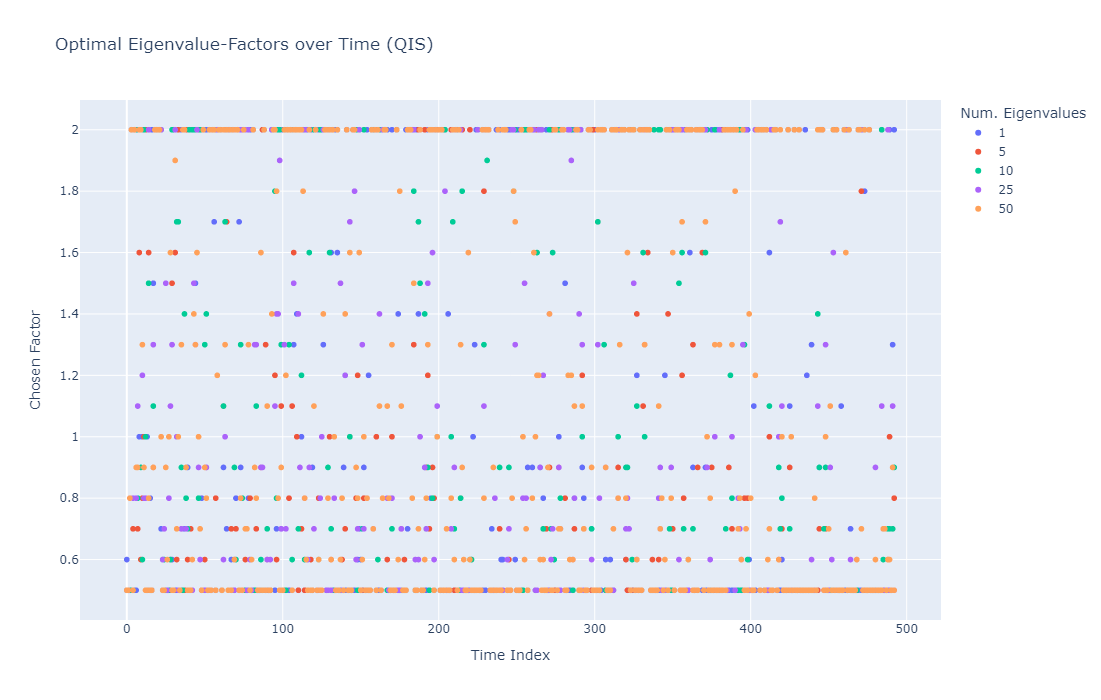

In [26]:
px.scatter(res, height=700, title="Optimal Eigenvalue-Factors over Time (QIS)",
          labels={"variable": "Num. Eigenvalues", "value": "Chosen Factor", "index": "Time Index"})